# SARCOS Dataset Problem 
----------------------------
Models applied to the SARCOS Dataset:  
Linear Regression  
K-NN  
RF  
Gaussian Process  


We also create a linear and sinusoidal toy problem to sense check the models.

In [1]:
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tqdm.notebook import tqdm
from scipy.spatial import distance
from scipy.optimize import minimize

### Toy problem/data

In [2]:
#Toy 1D data set:
#Sinusoidal:
x_toy = np.linspace(-3,3,500)
y_sin = np.sin(x_toy)*0.5 +5 + np.random.normal(size = 500)*0.1 #Adding noise to the toy problem
#Linear:
y_lin = 2*x_toy + 5 + np.random.normal(size = 500)*0.1 #Adding noise to the toy problem

In [3]:
#Linear:
x_Toy, x_Toy_test, y_Toy, y_Toy_test = train_test_split(x_toy, y_lin, test_size=0.20, random_state=101)

#Sinusoidal:
xsin_Toy, xsin_Toy_test, ysin_Toy, ysin_Toy_test = train_test_split(x_toy, y_sin, test_size=0.20, random_state=101)

### Sarcos Data

In [4]:
sarcos = pd.read_csv('sarcos_inv.csv', header = None).values

In [5]:
xt_, xtst_, yt, ytst = train_test_split(sarcos[:,:-1], sarcos[:,-1], train_size=0.9, random_state=101)

In [6]:
xtst_ = xtst_[:50]
ytst = ytst[:50]

Here we standardize the x-values using the mean and unit standard deviation for each feature in the training data_set.

In [7]:
scaler = preprocessing.StandardScaler().fit(xt_)
xt, xtst = scaler.transform(xt_), scaler.transform(xtst_)

In [8]:
def calc_mse(Prediction, Y):
    mse = np.mean(np.square(Prediction - Y))
    return mse

# 1) Linear Regression  
## (using closed form solution)

Here we build the LinearRegression class. The Linear Regression is trained using the closed form solution:

$$ \hat{\beta} = (X^{T}X)^{-1}X^{T}y $$

In [9]:
class LinearRegression():
    
    def __init__(self, intercept = True):
        self.intercept = intercept
    
    def fit(self, X, Y):
        if self.intercept == True:
            if len(X.shape) == 1:
                X = X.reshape(-1,1)
                X = np.insert(X,0,1,1)
                w = (np.linalg.inv(X.T @ X)) @ X.T @ Y

                self.B = w[1:]
                self.c = w[0]
                
            else:
                X = np.insert(X,0,1,1)
                w = np.linalg.inv(X.T @ X) @ X.T @ Y

                self.B = w[1:]
                self.c = w[0]
        else:
            w = np.linalg.inv(X.T @ X) @ X.T @ Y
            self.B = w
            self.c = 0
        return self
            
    def predict(self, X_t):
        if len(X_t.shape) == 1:
            X_t = X_t.reshape(-1,1)
            Prediction = X_t @ self.B + self.c
        else:
            Prediction = X_t @ self.B + self.c
        
        return Prediction

### Sarcos LR

In [10]:
model = LinearRegression()
model.fit(xt,yt)
prediction = model.predict(xtst)

In [11]:
calc_mse(prediction,ytst)

16.766759879376508

### Toy Problem LR
Linear

In [12]:
model_toy_lin = LinearRegression()
model_toy_lin.fit(x_Toy,y_Toy)
prediction_toy_lin = model_toy_lin.predict(x_Toy_test)

In [13]:
calc_mse(prediction_toy_lin, y_Toy_test)

0.011002277869663563

Sinusoidal

In [14]:
model_toy_sin = LinearRegression()
model_toy_sin.fit(xsin_Toy,ysin_Toy)
prediction_toy_sin = model_toy_sin.predict(xsin_Toy_test)

In [15]:
calc_mse(prediction_toy_sin, ysin_Toy_test)

0.05054398983318002

### Plots for LR Toy Problem

In [16]:
x_Toy_test_ = x_Toy_test[np.argsort(x_Toy_test)]
prediction_toy_lin_ = prediction_toy_lin[np.argsort(x_Toy_test)]
y_Toy_test_ = y_Toy_test[np.argsort(x_Toy_test)]

In [17]:
xsin_Toy_test_ = x_Toy_test[np.argsort(xsin_Toy_test)]
prediction_toy_sin_ = prediction_toy_sin[np.argsort(xsin_Toy_test)]
ysin_Toy_test_ = ysin_Toy_test[np.argsort(xsin_Toy_test)]

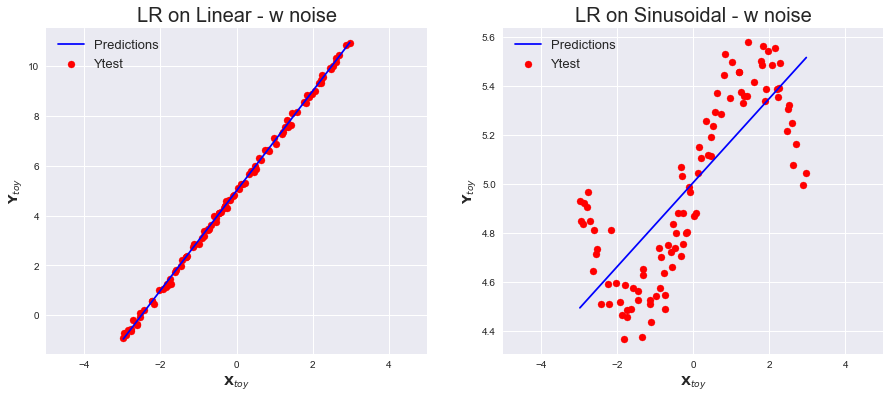

In [18]:
plt.style.use('seaborn')

plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.plot(x_Toy_test_, prediction_toy_lin_, color = 'b', label='Predictions')
plt.scatter(x_Toy_test_, y_Toy_test_, color = 'r', label='Ytest')
plt.legend(prop={'size': 13})
plt.title('LR on Linear - w noise', fontsize=20)
plt.xlim(-5,5)
plt.xlabel('$\mathbf{X}_{toy}$', size = 13)
plt.ylabel('$\mathbf{Y}_{toy}$', size = 13)

plt.subplot(1,2,2)
plt.plot(xsin_Toy_test_, prediction_toy_sin_, color = 'b', label='Predictions')
plt.scatter(xsin_Toy_test_, ysin_Toy_test_, color = 'r', label='Ytest')
plt.legend(prop={'size': 13})
plt.title('LR on Sinusoidal - w noise', fontsize=20)
plt.xlim(-5,5)
plt.xlabel('$\mathbf{X}_{toy}$', size = 13)
plt.ylabel('$\mathbf{Y}_{toy}$', size = 13)



plt.show()
#plt.savefig('LR_toy_plots', transparent=False)

# 2) K-NN

In [19]:
class KNN():

    def dist_matrix(self, X, Xt):
        if len(X.shape) == 1:
            X = X[:, None]
            Xt = Xt[:, None]
            
        euc_dist_ = 0
        for i in range(X.shape[-1]):
            euc_dist_ += np.square(X[:,i][None] - Xt[:,i][:,None])


        return np.sqrt(euc_dist_)
            
        
    def predict(self, dist_m, Y, K):
        NNs = np.argsort(dist_m)[:,:K]
        
        w_d = np.zeros((len(NNs),K))
        for i in range(len(NNs)):
            w_d[i,:] = dist_m[i,NNs[i]]
        
        denom = np.sum((1/w_d), axis=1)
        weighting = (1/w_d)/denom[:,None]
        
        predictions = np.sum((Y[NNs] * weighting), axis=1)
        
        return predictions
    

In [20]:
def Grid_Search(y_train, y_test, d_matrix, range_start, range_end):

    MSE_gridsearch = np.zeros((range_end - range_start))

    model_Grid_Srch = KNN()

    for K in tqdm(range(range_start,range_end)):

        predictions = model_Grid_Srch.predict(d_matrix, y_train, K)

        MSE_sarcos = calc_mse(predictions, y_test)

        MSE_gridsearch[K-1] = MSE_sarcos

    idx = np.argsort(MSE_gridsearch)[0]

    K = idx+1

    MSE_ = MSE_gridsearch[idx]

    return K, MSE_, MSE_gridsearch

### SARCOS K-NN

In [21]:
idx_k =round(0.6*xt.shape[0])
xt_k = xt[:idx_k]
yt_k = yt[:idx_k]

model_knn = KNN()
dist_matrix = model_knn.dist_matrix(xt_k,xtst)

In [22]:
k, mse, results = Grid_Search(yt_k, ytst, dist_matrix, 1, 21)

  0%|          | 0/20 [00:00<?, ?it/s]

In [23]:
(k,mse)

(9, 10.514521517529474)

### Toy Problem K-NN

Linear

In [24]:
model_knn_t_lin = KNN()
dist_matrix_toy_lin = model_knn_t_lin.dist_matrix(x_Toy, x_Toy_test)
k_toy_lin, mse_toy_lin, results_toy_lin = Grid_Search(y_Toy, y_Toy_test, dist_matrix_toy_lin, 1, 21)

  0%|          | 0/20 [00:00<?, ?it/s]

In [25]:
(k_toy_lin, mse_toy_lin)

(20, 0.011470740169168691)

Sinusoidal 

In [26]:
model_knn_t_sin = KNN()
dist_matrix_toy_sin = model_knn_t_sin.dist_matrix(xsin_Toy, xsin_Toy_test)
k_toy_sin, mse_toy_sin, results_toy_sin = Grid_Search(ysin_Toy, ysin_Toy_test, dist_matrix_toy_sin, 1, 21)

  0%|          | 0/20 [00:00<?, ?it/s]

In [27]:
(k_toy_sin, mse_toy_sin)

(20, 0.008829897077987713)

### Plots for KNN Toy Problem

In [28]:
preds_knn_t_lin = model_knn_t_lin.predict(dist_matrix_toy_lin, y_Toy, k_toy_lin)
preds_knn_t_lin_ = preds_knn_t_lin[np.argsort(x_Toy_test)]

In [29]:
preds_knn_t_sin = model_knn_t_sin.predict(dist_matrix_toy_sin, ysin_Toy, k_toy_sin)
preds_knn_t_sin_ = preds_knn_t_sin[np.argsort(xsin_Toy_test)]

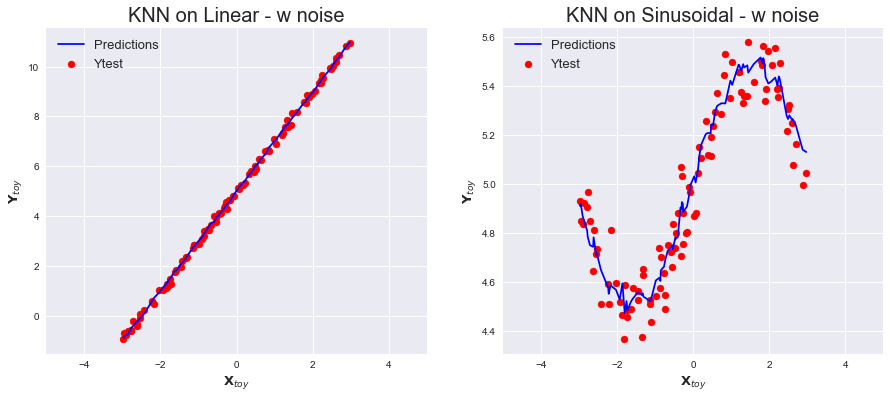

In [30]:
plt.style.use('seaborn')

plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.plot(x_Toy_test_, preds_knn_t_lin_, color = 'b', label='Predictions')
plt.scatter(x_Toy_test_, y_Toy_test_, color = 'r', label='Ytest')
plt.legend(prop={'size': 13})
plt.title('KNN on Linear - w noise', fontsize=20)
plt.xlim(-5,5)
plt.xlabel('$\mathbf{X}_{toy}$', size = 13)
plt.ylabel('$\mathbf{Y}_{toy}$', size = 13)

plt.subplot(1,2,2)
plt.style.use('seaborn')
plt.plot(xsin_Toy_test_, preds_knn_t_sin_, color = 'b', label='Predictions')
plt.scatter(xsin_Toy_test_, ysin_Toy_test_, color = 'r', label='Ytest')
plt.legend(prop={'size': 13})
plt.title('KNN on Sinusoidal - w noise', fontsize=20)
plt.xlim(-5,5)
plt.xlabel('$\mathbf{X}_{toy}$', size = 13)
plt.ylabel('$\mathbf{Y}_{toy}$', size = 13)


plt.show()
#plt.savefig('KKN_toy_plots', transparent=False)

# 3) Random Forest

In [31]:
class Random_Forest():
    
    def split(self, x, y):
    
        var_start = np.var(y)*len(y)

        best = {'infogain' : -np.inf}
        
        if len(x.shape) == 1:
            x = x[:,None]
            
        for i in range(x.shape[1]):
            for split in np.linspace(np.min(np.unique(x[:,i])),np.max(np.unique(x[:,i])),20):
                left = x[:,i]<=split
                right = x[:,i]>split #include split value on both sides to alleviate risk of left/right bias

                var_left = np.var(y[left])*len(y[left])
                var_right = np.var(y[right])*len(y[right])

                infogain = var_start - (var_left + var_right)

                if infogain > best['infogain']:
                    best = {'feature' : i,
                                'split' : split,
                                'infogain' : infogain, 
                                'left_indices' : np.where(left)[0],
                                'right_indices' : np.where(right)[0]}

        return best


    def tree(self, x, y, leaf_threshold, m_depth = np.inf):
        
        if len(x.shape) == 1:
            x = x[:,None]
        
        if m_depth==1 or len(y) <= leaf_threshold:

            return {'leaf' : True, 'prediction' : np.mean(y)}

        else:
            split_ = self.split(x, y)

            left = self.tree(x[split_['left_indices'],:], 
                             y[split_['left_indices']], leaf_threshold, m_depth - 1)
            right = self.tree(x[split_['right_indices'],:], 
                              y[split_['right_indices']], leaf_threshold, m_depth - 1)

            return {'leaf' : False,
                    'feature' : split_['feature'],
                    'split' : split_['split'],
                    'infogain' : split_['infogain'],
                    'left' : left,
                    'right' : right}
        
    def RF(self, x, y, no_trees=10, leaf_threshold = 10, m_depth = 40, samplesize=4000):
        Random_forest = []
        for i in tqdm(range(no_trees)):
            exemplars = np.random.choice(len(x), samplesize, replace=True)

            bag_xtrain = x[exemplars]

            bag_ytrain = y[exemplars]

            Random_forest.append(self.tree(bag_xtrain, bag_ytrain, leaf_threshold, m_depth))

        return Random_forest
    
    
    def build_predicts(self, tree, testdata):
        
        if len(testdata.shape) == 1:
            testdata = testdata[:, None]
        
        build = np.empty(testdata.shape[0], dtype=float)
        build.fill(-1)
        indx = np.arange(testdata.shape[0])

        def traverse(node, indx):
            nonlocal testdata
            nonlocal build

            if node['leaf']:
                build[indx] = node['prediction']

            else:
                going_left = testdata[indx, node['feature']] <= node['split']
                left_indices = indx[going_left]
                right_indices = indx[np.logical_not(going_left)]

                if left_indices.shape[0] > 0:
                    traverse(node['left'], left_indices)

                if right_indices.shape[0] > 0:
                    traverse(node['right'], right_indices)

        traverse(tree, indx)
        return build
    
    def predict(self, rf, Xt):
        
        predictions_ = []
        for tree in rf:
            predictions_.append(model_RF.build_predicts(tree, Xt))

        stack = np.zeros((len(predictions_[0]),len(predictions_)))

        for g in range(len(predictions_)):
            stack[:,g] = predictions_[g]

        predictions = np.mean(stack, axis=-1)
        
        return predictions

### SARCOS RF

In [38]:
idx_rf = round(0.6*xt.shape[0])
xt_rf  = xt[:idx_rf]
yt_rf  = yt[:idx_rf]

model_RF = Random_Forest()
rf = model_RF.RF(xt_rf,yt_rf,10,10,100, 1000)
predictions_rf = model_RF.predict(rf, xtst)

  0%|          | 0/10 [00:00<?, ?it/s]

In [39]:
calc_mse(predictions_rf, ytst)

27.38467239737777

### Toy Problem RF

Linear

In [40]:
model_RF_t_lin = Random_Forest()
rf_t_lin = model_RF_t_lin.RF(x_Toy, y_Toy, 100, 10, 40, 500)
predictions_rf_t_lin = model_RF.predict(rf_t_lin, x_Toy_test)

  0%|          | 0/100 [00:00<?, ?it/s]

In [41]:
calc_mse(predictions_rf_t_lin, y_Toy_test)

0.014553697175121186

Sinusoidal 

In [42]:
model_RF_t_sin = Random_Forest()
rf_t_sin = model_RF_t_sin.RF(xsin_Toy, ysin_Toy, 100, 10, 40, 500)
predictions_rf_t_sin = model_RF.predict(rf_t_sin, xsin_Toy_test)

  0%|          | 0/100 [00:00<?, ?it/s]

In [43]:
calc_mse(predictions_rf_t_sin, ysin_Toy_test)

0.010013167469593031

### Plots for RF Toy Problem

In [44]:
predictions_rf_t_lin_ = predictions_rf_t_lin[np.argsort(x_Toy_test)]

In [45]:
predictions_rf_t_sin_ = predictions_rf_t_sin[np.argsort(x_Toy_test)]

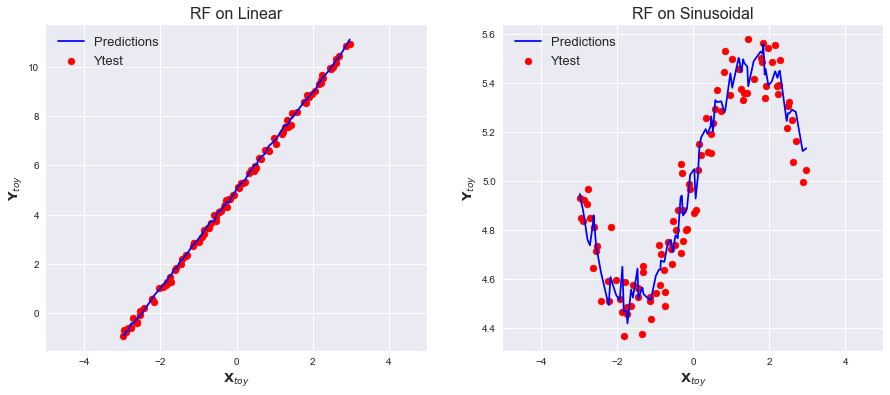

In [46]:
plt.style.use('seaborn')

plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.plot(x_Toy_test_, predictions_rf_t_lin_, color = 'b', label='Predictions')
plt.scatter(x_Toy_test_, y_Toy_test_, color = 'r', label='Ytest')
plt.legend(prop={'size': 13})
plt.title('RF on Linear', fontsize=16)
plt.xlim(-5,5)
plt.xlabel('$\mathbf{X}_{toy}$', size = 13)
plt.ylabel('$\mathbf{Y}_{toy}$', size = 13)

plt.subplot(1,2,2)
plt.plot(xsin_Toy_test_, predictions_rf_t_sin_, color = 'b', label='Predictions')
plt.scatter(xsin_Toy_test_, ysin_Toy_test_, color = 'r', label='Ytest')
plt.legend(prop={'size': 13})
plt.title('RF on Sinusoidal', fontsize=16)
plt.xlim(-5,5)
plt.xlabel('$\mathbf{X}_{toy}$', size = 13)
plt.ylabel('$\mathbf{Y}_{toy}$', size = 13)


plt.show()
#plt.savefig('RF_toy_plots', transparent=False)

# 4) Gaussian Process

#### GP Code

In [55]:
class Gaussian_Process():
    
    def kernel(self, x1, x2, l, s):
    
        if len(x1.shape) == 1:
            x1 = x1[:,None]
            x2 = x2[:,None]

        euc_dist_2 = np.square(distance.cdist(x1,x2, 'euclidean'))

        k = s * np.exp(-0.5 * euc_dist_2/(l**2))

        return k

    def n_loglikelihood(self, Xt, Yt):

            def  optimisation(hps): 
                #Hyperparameters used optimized from scipy minimizing function, minimizing negative loglikelihood
                n      =len(Xt)

                l      =hps[0]

                s      =hps[1]

                sig    =hps[2]

                k_sig_I = self.kernel(Xt, Xt, l, s) + sig**2 * np.eye(n)

                k_sig_I_inv = np.linalg.inv(k_sig_I)

                k_sig_I_det = np.linalg.det(k_sig_I)

                loglikelihood = -(n/2) * np.log(2*np.pi) - (1/2) * np.log(k_sig_I_det) - (1/2) * Yt.T @ k_sig_I_inv @ Yt        

                negativeloglhood= -1 * loglikelihood

                return negativeloglhood
            return optimisation
    
    def posteriors(self, Xt, Yt, Xtst, l, s, sig):
    
        n = len(Xt)

        k_sig_I = self.kernel(Xt, Xt, l, s) + np.square(sig) * np.eye(n)

        k_t_tst = self.kernel(Xt, Xtst, l, s)

        k_tst   = self.kernel(Xtst, Xtst, l, s)

        k_sig_I_inv = np.linalg.inv(k_sig_I)

        #Predictions/mu-vector
        mu = k_t_tst.T @ k_sig_I_inv @ Yt

        #Covariance matrix
        cov = k_tst - k_t_tst.T @ k_sig_I_inv @ k_t_tst

        return mu, cov
        

    def Hp_tuning(self, Xt, Yt, Xtst):
        #Implementing the scipy.optimize  minimize fucntion in order to tune s,l,sig**2 in order to minimize 
        #the n_log_likelihood value thus optimizing the hyperparameters. 
        #these are initiated as 1,1,1 in the minize function

        Optimized = minimize(self.n_loglikelihood(Xt, Yt), [1, 1, 1], bounds=((1e-8, None), (1e-8, None),(1e-8, None)), method='Nelder-Mead') 
    
        return Optimized

### SARCOS GP

In [ ]:
idx_gp = round(0.10*xt.shape[0])
xt_gp  = xt[:idx_gp]
yt_gp  = yt[:idx_gp]

model_GP  = Gaussian_Process()
optimised = model_GP.Hp_tuning(xt_gp, yt_gp, xtst)

l     = optimised.x[0]
s     = optimised.x[1]
sig_2 = optimised.x[2]

mu_sarcos, cov_sarcos = posteriors(xt_gp, yt_gp, xtst, l, s, sig_2)

In [ ]:
calc_mse(mu_sarcos, ytst)

### Toy Problem GP

Linear

In [60]:
model_GP_tlin  = Gaussian_Process()
optimised_tlin = model_GP_tlin.Hp_tuning(x_Toy, y_Toy, x_Toy_test)

l_tl     = optimised_tlin.x[0]
s_tl     = optimised_tlin.x[1]
sig_2_tl = optimised_tlin.x[2]

mu_tlin, cov_tlin = model_GP_tlin.posteriors(x_Toy, y_Toy, x_Toy_test, l_tl, s_tl, sig_2_tl)

<ipython-input-55-4c18623de3a3>:33: RuntimeWarning: divide by zero encountered in log
  loglikelihood = -(n/2) * np.log(2*np.pi) - (1/2) * np.log(k_sig_I_det) - (1/2) * Yt.T @ k_sig_I_inv @ Yt


In [61]:
calc_mse(mu_tlin, y_Toy_test)

0.01176627113122011

Sinusoidal 

In [62]:
model_GP_tsin  = Gaussian_Process()
optimised_tsin = model_GP_tsin.Hp_tuning(xsin_Toy, ysin_Toy, xsin_Toy_test)

l_ts     = optimised_tsin.x[0]
s_ts     = optimised_tsin.x[1]
sig_2_ts = optimised_tsin.x[2]

mu_tsin, cov_tsin = model_GP_tsin.posteriors(xsin_Toy, ysin_Toy, xsin_Toy_test, l_ts, s_ts, sig_2_ts)

<ipython-input-55-4c18623de3a3>:33: RuntimeWarning: divide by zero encountered in log
  loglikelihood = -(n/2) * np.log(2*np.pi) - (1/2) * np.log(k_sig_I_det) - (1/2) * Yt.T @ k_sig_I_inv @ Yt


In [63]:
calc_mse(mu_tsin, ysin_Toy_test)

0.009239147941830096

### Plots for GP Toy Problem

#### Linear (with noise)

In [64]:
mu_tlin_   = mu_tlin[np.argsort(x_Toy_test)]
stdv_tlin  = np.sqrt(np.diag(cov_tlin))
stdv_tlin_ = stdv_tlin[np.argsort(x_Toy_test)]

upper_tlin = mu_tlin_ + stdv_tlin_*2
lower_tlin = mu_tlin_ - stdv_tlin_*2

In [65]:
mu_tsin_   = mu_tsin[np.argsort(xsin_Toy_test)]
stdv_tsin  = np.sqrt(np.diag(cov_tsin))
stdv_tsin_ = stdv_tsin[np.argsort(xsin_Toy_test)]

upper_tsin = mu_tsin_ + stdv_tsin_*2
lower_tsin = mu_tsin_ - stdv_tsin_*2

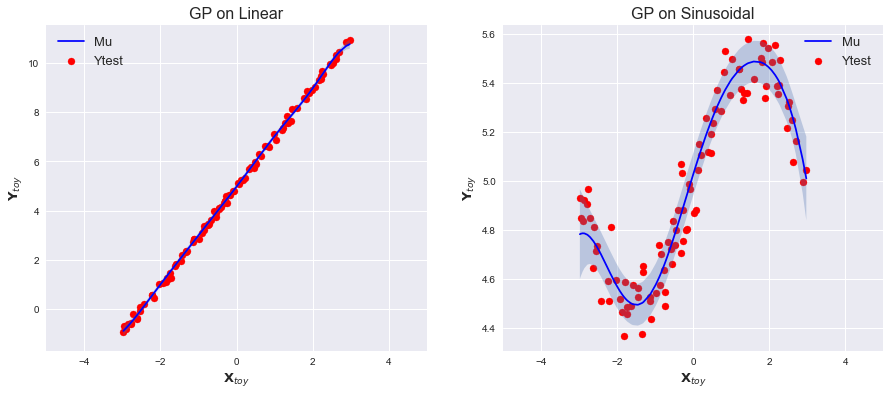

In [66]:
plt.style.use('seaborn')

plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.plot(x_Toy_test_, mu_tlin_, color = 'b', label='Mu')
plt.scatter(x_Toy_test_, y_Toy_test_, color = 'r', label='Ytest')
plt.legend(prop={'size': 13})
plt.title('GP on Linear', fontsize=16)
plt.xlim(-5,5)
plt.fill_between(x_Toy_test_, upper_tlin, lower_tlin, alpha=0.3)
plt.xlabel('$\mathbf{X}_{toy}$', size = 13)
plt.ylabel('$\mathbf{Y}_{toy}$', size = 13)

plt.subplot(1,2,2)
plt.plot(xsin_Toy_test_, mu_tsin_, color = 'b', label='Mu')
plt.scatter(xsin_Toy_test_, ysin_Toy_test_, color = 'r', label='Ytest')
plt.legend(prop={'size': 13})
plt.title('GP on Sinusoidal', fontsize=16)
plt.xlim(-5,5)
plt.fill_between(xsin_Toy_test_, upper_tsin, lower_tsin, alpha=0.3)
plt.xlabel('$\mathbf{X}_{toy}$', size = 13)
plt.ylabel('$\mathbf{Y}_{toy}$', size = 13)

plt.show()
#plt.savefig('GP_toy_plots', transparent=False)